In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import datetime
import ssl


In [2]:
def getSentiment(message):
    return  sia.polarity_scores(message)['compound']

def convertDate(date):
    dates = date.split("-")
    convert = datetime.date(int(dates[0]), int(dates[1]), int(dates[2]))
    return convert

# Single Thread Temporal Analysis

In [3]:
#Load Data
data = pd.read_csv("GawaherSentiment.csv")
threads = data["ThreadID"].unique()
#Load Sentiment analyzer


In [4]:
#Get thread
num = -4
thread = data[data["ThreadID"]== threads[num]]
thread = thread.reset_index(drop = True)

#get all messages
messages = thread["Message"].copy()
threadName = thread["ThreadName"].iloc[0]


# Order by Datetime 

In [5]:
for i in range(0,len(thread)):
    thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
    
thread = thread.sort_values(by = ["P_Date",'MessageID'])

C:\Users\Le\AppData\Local\Temp\ipykernel_13728\640913224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])


# Sentiment Time Series

In [6]:
means = []
steps = []
for i in thread["AllenNLP"]:
    steps.append(i)
    means.append(np.mean(steps))

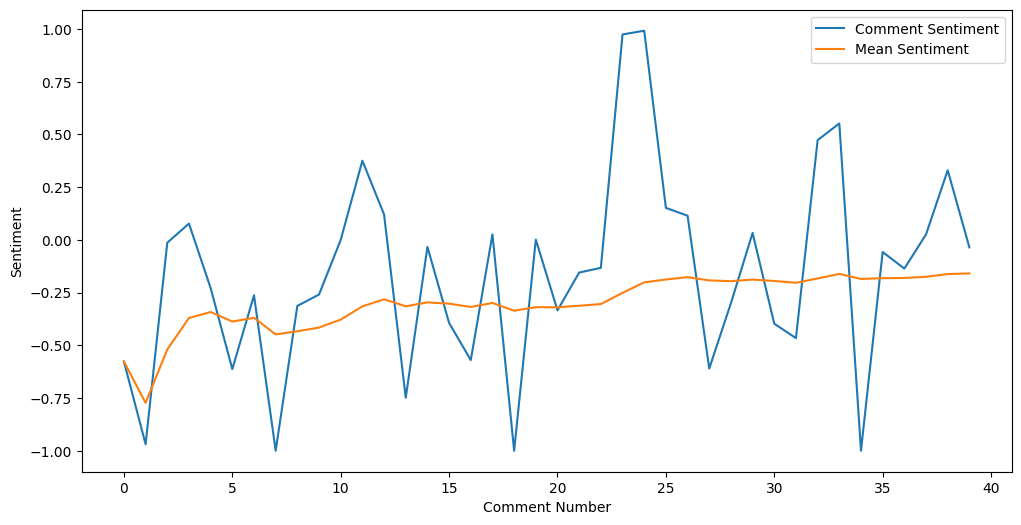

In [7]:
step = np.arange(0,len(thread))
plt.figure(figsize = (12,6))
plt.plot(step, thread["AllenNLP"], label = "Comment Sentiment")
plt.plot(step, means, label = "Mean Sentiment")
plt.xlabel("Comment Number")
plt.ylabel("Sentiment")
plt.legend();

# Multi Thread Time Series

In [8]:
def getThread(threadNumber, data):
    threads = data["ThreadID"].unique()
    thread = data[data["ThreadID"]== threads[threadNumber]]
    thread = thread.reset_index(drop = True)

    #get all messages
    messages = thread["Message"].copy()
    threadName = thread["ThreadName"].iloc[0]
    
    return messages

def getSentiments(messages):
    nltkSentiment = []
    rollingMean = []
    rollingStd = []

    for i in messages:
        nltkSentiment.append(i)
        rollingMean.append(np.mean(nltkSentiment))
        rollingStd.append(np.std(nltkSentiment))
        
    return nltkSentiment, rollingMean, rollingStd

In [9]:
plt.figure(figsize = (12,6))
steps = []
sentimentTs = []
sentimentMean = []
sentimentStd = []

for i in data["ThreadID"].unique():
   
    threadSentiment = data[data["ThreadID"] == i]["AllenNLP"]
    sentiment = getSentiments(threadSentiment)
    
    t = np.arange(0,len(sentiment[0]))
    
    steps.append(t)
    sentimentTs.append(sentiment[0])
    sentimentMean.append(sentiment[1])
    sentimentStd.append(sentiment[2])
    

<Figure size 1200x600 with 0 Axes>

Do negitavely sentimented threads have higher std?
Get OP mean sentiment, maybe track the sentiment change in individual users

-0.072224919612591 -0.27908386088126375


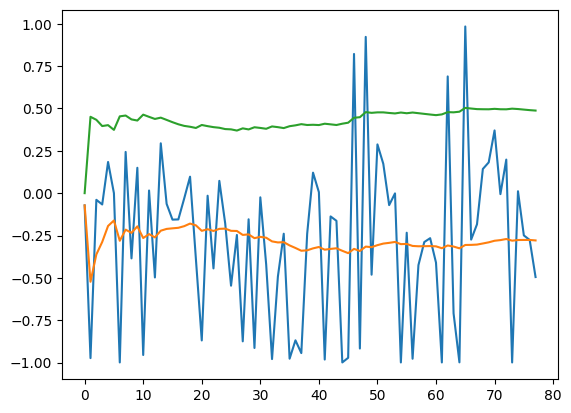

In [10]:
i = 0
plt.plot(steps[i],sentimentTs[i])
plt.plot(steps[i],sentimentMean[i])
plt.plot(steps[i],sentimentStd[i])
print(sentimentTs[i][0], sentimentMean[i][-1])

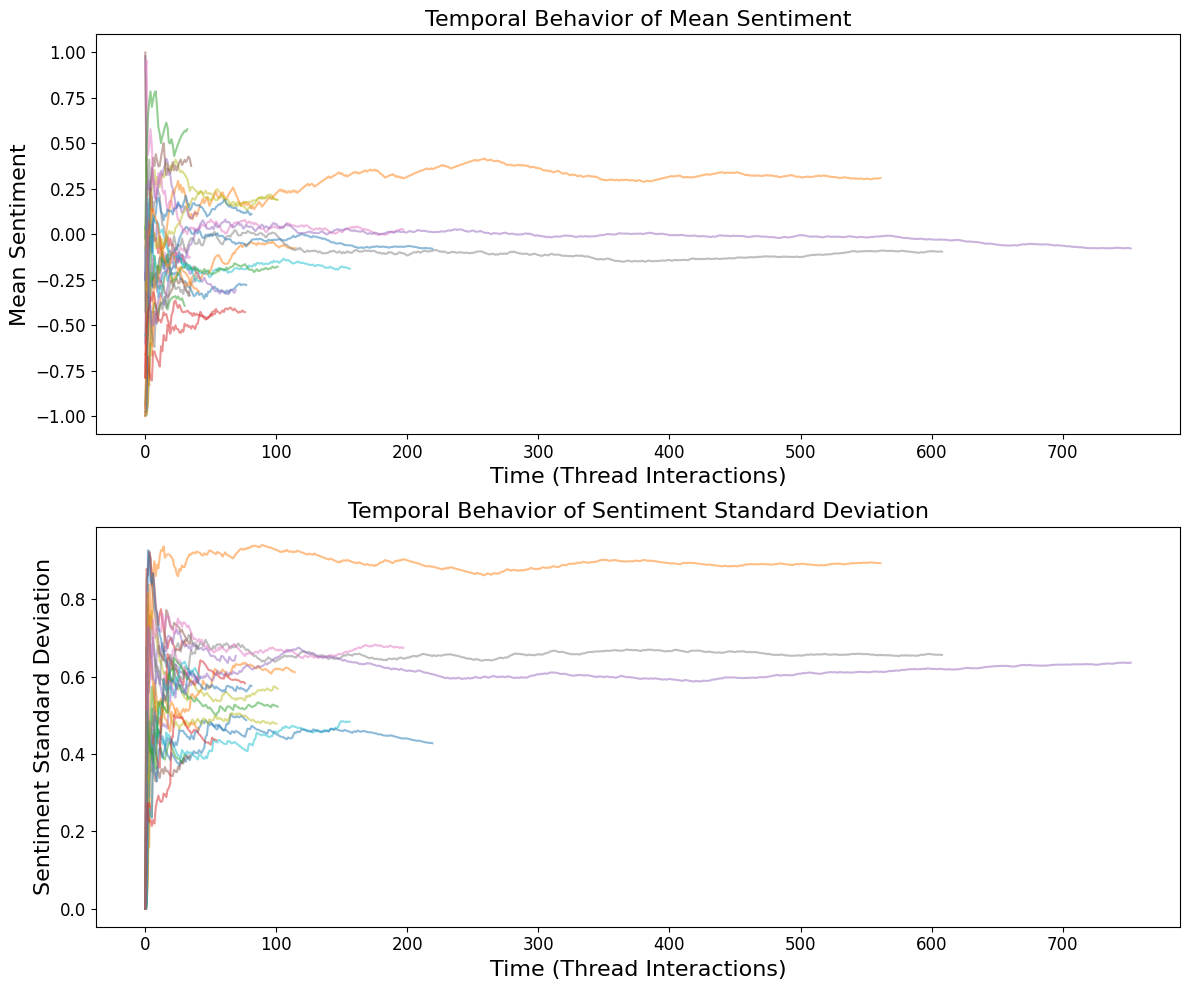

In [11]:
font = 16
tick = 12

plt.figure(figsize = (12,10))

n = 25#len(steps)

plt.subplot(2,1,1)
for i in range(0,n):
    plt.plot(steps[i],sentimentMean[i], alpha = .5)
plt.xlabel("Time (Thread Interactions)",fontsize = font)
plt.ylabel("Mean Sentiment",fontsize = font)
plt.title("Temporal Behavior of Mean Sentiment",fontsize = font)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)


plt.subplot(2,1,2)
for i in range(0,n):
    plt.plot(steps[i],sentimentStd[i], alpha = .5)
plt.xlabel("Time (Thread Interactions)",fontsize = font)
plt.ylabel("Sentiment Standard Deviation",fontsize = font)
plt.title("Temporal Behavior of Sentiment Standard Deviation",fontsize = font)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)


plt.tight_layout()
plt.savefig("TemporalAnalysis.png")

In [12]:
color = []
stds = []
means = []
diff = []
count = 0
for i in sentimentMean:
    if i[0] >= 0:
        color.append(0)
    else:
        color.append(1)
    stds.append(sentimentStd[count][-1])
    means.append(i[-1])
    diff.append(i[-1]-i[0])
    count +=1

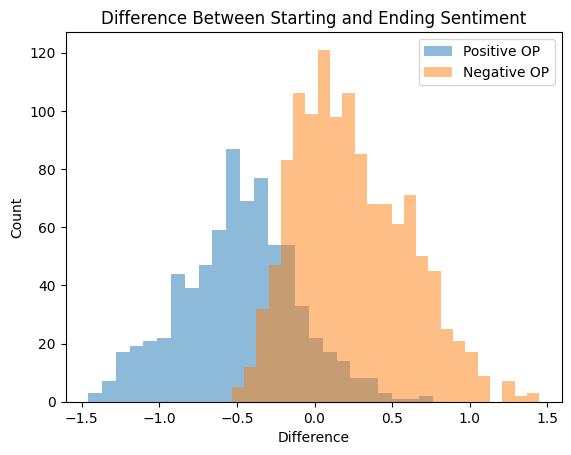

In [13]:
plt.hist(np.array(diff)[np.array(color) == 0], alpha = .5, label = "Positive OP", bins = 25)
plt.hist(np.array(diff)[np.array(color) == 1], alpha = .5, label = "Negative OP", bins = 25)
plt.title("Difference Between Starting and Ending Sentiment")
plt.ylabel("Count")
plt.xlabel("Difference")
plt.legend()
plt.savefig("TemporalDiference.png")

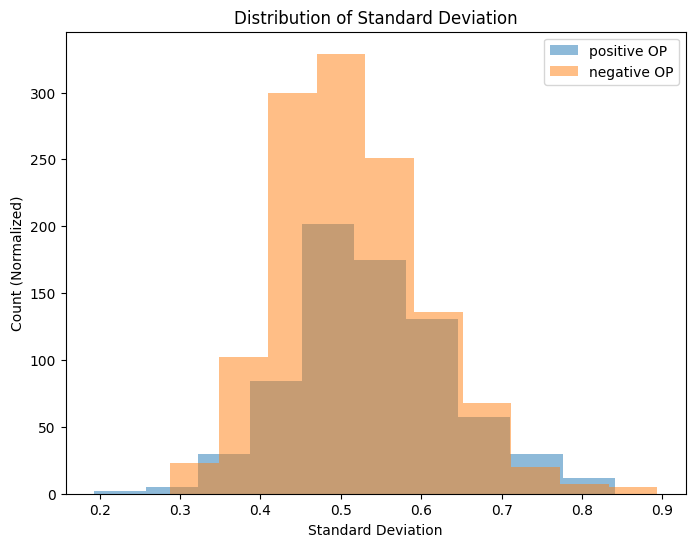

In [14]:
plt.figure(figsize = (8,6))

plt.hist(np.array(stds)[np.array(color) == 0], alpha = .5, label = "positive OP")
plt.hist(np.array(stds)[np.array(color) == 1], alpha = .5, label = "negative OP")
plt.title("Distribution of Standard Deviation")
plt.xlabel("Standard Deviation")
plt.ylabel("Count (Normalized)")
plt.legend()
plt.savefig("TemporalSTD.png")

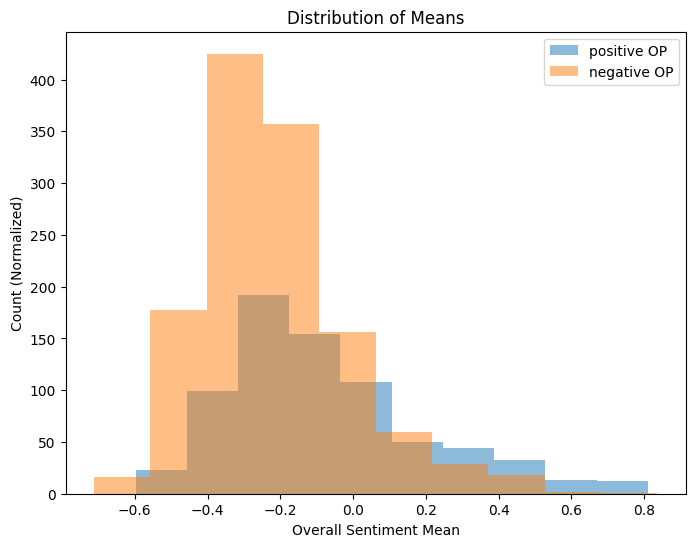

In [15]:
plt.figure(figsize = (8,6))

plt.hist(np.array(means)[np.array(color) == 0], alpha = .5, label = "positive OP")
plt.hist(np.array(means)[np.array(color) == 1], alpha = .5, label = "negative OP")
plt.title("Distribution of Means")
plt.xlabel("Overall Sentiment Mean")
plt.ylabel("Count (Normalized)")
plt.legend()
plt.savefig("TemporalMeans.png")

# Temporal Centralitiy Analysis

In [16]:
steps = []
centralityTs = []

#Get thread
for num in range(0,len(threads)):
    thread = data[data["ThreadID"]== threads[num]]
    thread = thread.reset_index(drop = True)

    #get all messages
    messages = thread["Message"].copy()
    threadName = thread["ThreadName"].iloc[0]

    encoder = dict(zip(thread["MemberID"].unique(),np.arange(0,len(thread["MemberID"].unique()))))
    thread["MemberID"] = thread["MemberID"].map(encoder)

    edges = []
    poster = []
    for i in range(0,len(thread)-1):
        poster.append(thread["MemberID"].iloc[i])
        edges.append([thread["MemberID"].iloc[i],thread["MemberID"].iloc[i+1]])

    centralMembers = []
    for step in range(1,len(poster)):
        G = nx.Graph()
        thisPoster = poster[:step+1]
        thisEdge = edges[:step]

        G.add_nodes_from(thisPoster)
        G.add_edges_from(thisEdge)
        nodeDict = dict(zip(thisPoster,thread["AllenNLP"].iloc[:step+1].to_numpy()))

        infoCentrality = nx.information_centrality(G)
        centralMember = list(infoCentrality.keys())[list(infoCentrality.values()).index(max(infoCentrality.values()))]

        centralMembers.append(centralMember)
        
    centralityTs.append(centralMembers)
    steps.append(np.arange(0,len(centralMembers)))

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\networkx\algorithms\centrality\current_flow_closeness.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  betweenness[v] = 1 / (betweenness[v])
C:\Users\Le\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

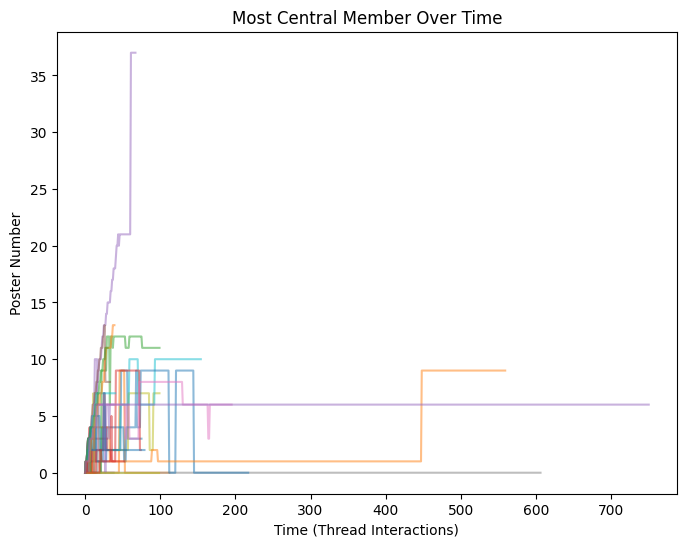

In [17]:
plt.figure(figsize = (8,6))

for i in range(0,25):#len(steps)):
    plt.plot(steps[i],centralityTs[i],alpha = .5)
    
plt.title("Most Central Member Over Time")
plt.ylabel("Poster Number")
plt.xlabel("Time (Thread Interactions)")
plt.savefig("CentralityTs.png")

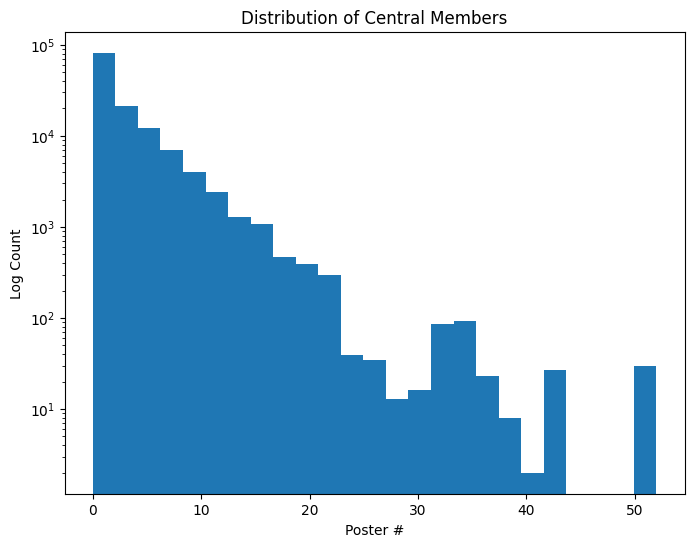

In [18]:
plt.figure(figsize = (8,6))
plt.hist(np.concatenate(centralityTs), bins = 25)
plt.yscale("log")
plt.title("Distribution of Central Members")
plt.xlabel("Poster #")
plt.ylabel("Log Count")
plt.savefig("TemporalCentrality.png")

### Analysis of None Central OP

In [68]:
from statistics import mode
from matplotlib.ticker import PercentFormatter


In [48]:
odd = []

for i in centralityTs:
    odd.append(mode(i))

In [57]:
percentages = []
odd = np.array(odd)

for i in np.unique(odd):
    percentages.append(len(odd[odd == i])/len(odd))

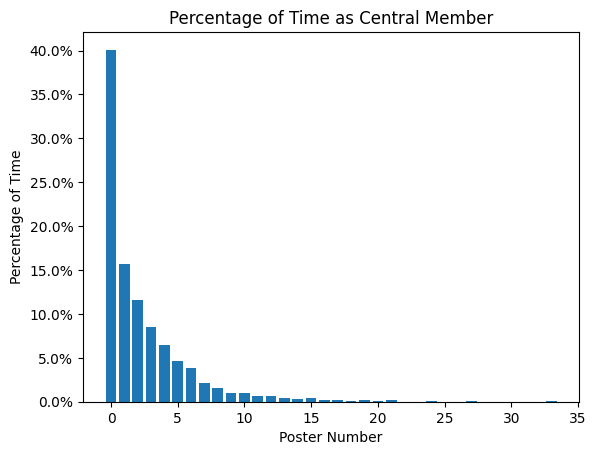

In [70]:
plt.bar(np.unique(odd), np.array(percentages))

plt.title("Percentage of Time as Central Member")
plt.ylabel("Percentage of Time")
plt.xlabel("Poster Number")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [97]:
other = []

zeros = []

for i in range(0,len(centralityTs)):
    if mode(centralityTs[i]) != 0:
        other.append(i)
    else:
        zeros.append(i)

In [99]:
lengths = []
allLengths = []

for i in zeros:
    allLengths.append(len(data[data["ThreadID"] == threads[i]]))

for i in other:
    lengths.append(len(data[data["ThreadID"] == threads[i]]))

In [149]:
print(np.mean(lengths), np.std(lengths))

72.6590717299578 69.65687007399488


In [150]:
print(np.mean(allLengths),  np.std(allLengths))

63.88272383354351 56.48026464367952


In [118]:
np.unique(data[data["ThreadID"] == threads[0]]["MemberID"])

array(['Arif', 'Crystal Eyes', 'DAWATEISLAMI.NET mustvisit', 'Danish',
       'Guest_Sulemaan_*', 'Guest_amani_*', 'IbnSina', 'Jawharah', 'Kale',
       'Mansoor Ansari', 'Mercyonmankind', 'Moustafa', 'Muezza',
       'Muhammad al Mustafa', 'Muslimah180', 'Paki Brother',
       'Rashed Amir', 'Red-Shift', 'Sia', 'Zahrah', 'dot', 'hyper~gal',
       'maranatha', 'mujahideen', 'o2cute4u', 'shiningstar'], dtype=object)

In [142]:
zeroComments = []
zeroCommentOP = []

otherComments = []
otherCommentOP = []

for i in zeros:

    comments = [sum(data[data["ThreadID"] == threads[i]]["MemberID"] == x) for x in np.unique(data[data["ThreadID"] == threads[i]]["MemberID"])]
    zeroComments.append(np.mean(comments))
    zeroCommentOP.append(comments[0])
    
for i in other: 
    comments = [sum(data[data["ThreadID"] == threads[i]]["MemberID"] == x) for x in np.unique(data[data["ThreadID"] == threads[i]]["MemberID"])]
    otherComments.append(np.mean(comments))
    otherCommentOP.append(comments[0])
    
    

In [148]:
print(np.mean(zeroComments), np.std(zeroComments))
print(np.mean(zeroCommentOP), np.std(zeroCommentOP))


5.1586535982101465 6.150006378661216
5.682219419924338 10.679317277831073


In [145]:
print(np.mean(otherComments), np.std(otherComments))
print(np.mean(otherCommentOP), np.std(otherCommentOP))

3.851488020182647 2.638556292816305
3.571308016877637 5.087937623394766
